# Загрузка данных

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import re
import numpy as np
from datasets import Dataset

In [3]:
!git clone https://github.com/ayugrishanova/from_RNC_with_love/

Cloning into 'from_RNC_with_love'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 341.29 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
dataset = pd.read_csv('/content/from_RNC_with_love/dataset/dataset.csv')

In [5]:
dataset

,id_replic,replic,html_text,sentiment
0,0,"Пора, я вас задержал; я хотел вам всё сказать....","Пора, <i>— озабоченно и чуть не с испугом подн...",fear
1,1,"Извините, мне что-то душно стало, Я выйду.","Извините, мне что-то душно стало, <i>— сказал ...",sadness
2,2,"Разумеется, законным браком.","Разумеется, законным браком.",neutral
3,3,"Ах, мамаша, какой он душка!","Ах, мамаша, какой он душка! <i>— сочувственно ...",joy
4,4,"Ишь, олух, бродит! словно во сне веревки вьет!...","Ишь, олух, бродит! словно во сне веревки вьет!...",disgust
...,...,...,...,...
2711,2711,"Эка, нашла кого выкрикнуть! Ничего вы здесь не...","Эка, нашла кого выкрикнуть! <i>— воскликнул, в...",disgust
2712,2712,"Ах, с детьми очень много хлопот!","Ах, с детьми очень много хлопот!",sadness
2713,2713,"Да разве не обидно, папенька! На дворе морозы,...","Да разве не обидно, папенька! На дворе морозы,...",sadness
2714,2714,Братец! Голубчик мой! Вы мне наместо отца родн...,Братец! Голубчик мой! Вы мне наместо отца родн...,fear


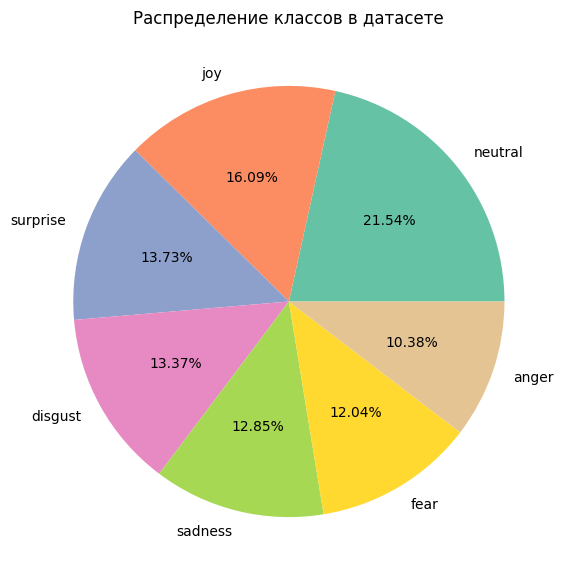

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 7))
data = dataset['sentiment'].value_counts().tolist()

plt.pie(data,
        autopct='%1.2f%%',
        labels=dataset['sentiment'].value_counts().index.tolist(),
        colors=sns.color_palette('Set2'))

ax.set_title("Распределение классов в датасете")
# show plot
plt.show()

# Функции для инференса и обучения

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import gc
import torch
from tqdm.auto import tqdm, trange
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from IPython.display import display
from torch.utils.data import DataLoader

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import precision_score, recall_score, f1_score


def binarize_label(label, num_classes):
    new_label = np.zeros(num_classes, dtype='float')
    new_label[label] = 1
    return new_label

def preprocess_function(example):
    return tokenizer(example['text'], truncation=True,
                     return_tensors="pt",
                     padding=True)

def tokenize_dataset(data, name_column, num_classes):
    id2label = {}
    label2id = {}
    my_labels = data[name_column].unique()
    for _ in range(len(my_labels)):
        id2label[_] = f'{my_labels[_]}'
        label2id[f'{my_labels[_]}'] = _
    dataset = []
    for _ in range(len(data)):
        dataset.append(
            {'label': binarize_label(label2id[data[name_column].iloc[_]], num_classes),
             'text': data.iloc[_].replic}
        )
    my_dataset = Dataset.from_list(dataset)
    my_dataset_split = my_dataset.train_test_split(0.3)
    my_dataset_unsplit = my_dataset.train_test_split(0.99)

    tokenized_dataset = my_dataset_split.map(preprocess_function, batched=True).remove_columns(['text'])
    tokenized_dataset_unsplit = my_dataset_unsplit.map(preprocess_function, batched=True).remove_columns(['text'])
    return id2label, label2id, tokenized_dataset, my_dataset_split, tokenized_dataset_unsplit

def print_confusionmatrix(dataset, model, num_labels):
    predicted = np.ndarray([])
    labels = np.argmax(dataset["test"]['label'], axis=1)
    model.eval()

    for example in dataset["test"]['text']:
        example_tokenized = tokenizer(example, return_tensors="pt").to('cuda')
        with torch.no_grad():
            logits = model(**example_tokenized).logits
            predicted_class_id = logits.argmax().item()
        predicted = np.append(predicted, int(predicted_class_id))


    cm = confusion_matrix(labels, predicted[1:], labels=np.arange(num_labels))

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.label2id)
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[0]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=model.config.label2id, yticklabels=model.config.label2id,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(num_labels):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
def make_dataloaders(dataset, tokenizer, batch_size):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        dataset['train'],
        batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
    )
    dev_dataloader = DataLoader(
        dataset['test'],
        batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
    )

    return train_dataloader, dev_dataloader

def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    ### YOUR CODE HERE
    ### MOVE MODEL TO DEVICE
    model.to(device)
    if is_train:
        #training
        ### CHANGE MODEL TO TRAIN OR EVAL MODE
        model.train()
        ### SET LOGGING VALUES
        training_loss = np.ndarray([])
        training_accuracy = np.ndarray([])
        ### ITERATE OVER DATALOADER
        for batch in loader:
            batch = batch.to(model.device)
            output = model(**batch)
            probabilities = output.logits
            labels = batch['labels']

            predicted_labels = torch.argmax(probabilities, dim=1)
            true_labels = torch.argmax(labels, dim=1)

            loss = criterion(probabilities, true_labels.to(torch.int64))
            accuracy_ = torch.mean((predicted_labels == true_labels).float()).item()
            ### BACKWARD IF TRAIN
            loss.backward()
            ### STEP WITH OPTIMIZER (DONT FORGET TO ZERO GRAD)
            optimizer.step()
            optimizer.zero_grad()
        ### UPDATE LOGGING VALUES WITH LOSS AND ACCURACY
            training_loss = np.append(training_loss, loss.item())
            training_accuracy = np.append(training_accuracy, accuracy_)
        ### RETURN LOGGED VALUES
        return training_loss.mean(), training_accuracy.mean()
    else:

        #validation
        ### CHANGE MODEL TO TRAIN OR EVAL MODE
        model.eval()
        ### SET LOGGING VALUES
        eval_loss = np.ndarray([])
        eval_accuracy = np.ndarray([])
        ### ITERATE OVER DATALOADER
        for batch in loader:
            batch = batch.to(model.device)
            output = model(**batch)
            probabilities = output.logits
            labels = batch['labels']

            predicted_labels = torch.argmax(probabilities, dim=1)
            true_labels = torch.argmax(labels, dim=1)

            loss = criterion(probabilities, true_labels.to(torch.int64))
            accuracy_ = torch.mean((predicted_labels == true_labels).float()).item()
            ### UPDATE LOGGING VALUES WITH LOSS AND ACCURACY
            eval_loss = np.append(eval_loss, loss.item())
            eval_accuracy = np.append(eval_accuracy, accuracy_)
        ### RETURN LOGGED VALUES
        return eval_loss.mean(), eval_accuracy.mean()

def training_process(model, criterion, optimizer, device, num_epochs,
                     train_dataloader, dev_dataloader):
    criterion = criterion
    optimizer = optimizer
    device = device
    num_epochs = num_epochs

    train_losses = np.ndarray([])
    train_accuracies = np.ndarray([])
    val_losses = np.ndarray([])
    val_accuracies = np.ndarray([])

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_accuracy = perform_epoch(model, train_dataloader, criterion=criterion,
                            optimizer=optimizer, device=device)
        train_losses = np.append(train_losses, train_loss)
        train_accuracies = np.append(train_accuracies, train_accuracy)

        val_loss, val_accuracy = perform_epoch(model, dev_dataloader, criterion=criterion,
                                        device=device)
        val_losses = np.append(val_losses, val_loss)
        val_accuracies = np.append(val_accuracies, val_accuracy)

        print(f"""\nEpoch - {epoch} : train_loss {train_loss}, train_accuracy {train_accuracy}
            \nEpoch - {epoch} : val_loss {val_loss}, val_accuracy {val_accuracy}""")
    return train_losses, train_accuracies, val_losses, val_accuracies

def get_metrics(dataset, model, id2label):
    labels_list = [[],
                   [],
                    [],
                    [],
                    [],
                    [],
                    []]
    predictions_list = [[], [], [],
                    [],
                    [],
                    [],
                    []]
    labels_labels = ['']

    for example in dataset:
        example_tokenized = tokenizer(example['text'], return_tensors="pt").to('cuda')
        with torch.no_grad():
            logits = model(**example_tokenized).logits
            predicted_class_id = logits.argmax().item()
        example_label = np.array(example['label']).argmax()

        labels_list[example_label].append(example_label)
        predictions_list[example_label].append(int(predicted_class_id))

    precisions = ['precision']
    recalls = ['recall']
    f1_weighteds = ['f1_weighted']
    f1_micros = ['f1_micro']
    f1_macros = ['f1_macro']

    for label in range(7):
        labels_labels.append(id2label[label])
        precision = precision_score(labels_list[label], predictions_list[label], average='weighted')
        recall = recall_score(labels_list[label], predictions_list[label], average='weighted')
        f1_weighted = f1_score(labels_list[label], predictions_list[label], average='weighted')
        f1_micro = f1_score(labels_list[label], predictions_list[label], average='micro')
        f1_macro = f1_score(labels_list[label], predictions_list[label], average='macro')

        precisions.append(precision)
        recalls.append(recall)
        f1_weighteds.append(f1_weighted)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)
    return pd.DataFrame(
        [precisions, recalls, f1_weighteds,
         f1_micros, f1_macros],
        columns=labels_labels
    )

# Инференс предобученной модели

[Ссылка на модель](https://huggingface.co/cointegrated/rubert-tiny2-cedr-emotion-detection)

In [7]:
inference_data = dataset[dataset.sentiment.isin(['neutral','joy',' sadness', 'surprise', 'fear', 'anger'])]

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection",
                                          device='cuda')
inference_model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection").to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

In [15]:
id2label, label2id, test_dataset_tokenized, test_dataset, test_unsplit = tokenize_dataset(inference_data, 'sentiment', 6)

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/1984 [00:00<?, ? examples/s]

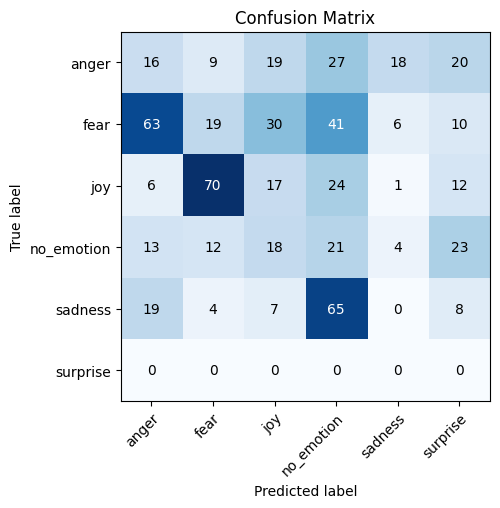

In [16]:
print_confusionmatrix(test_dataset, inference_model, 6)

# Дообучение модели

In [17]:
device = 'cuda'
num_labels = len(dataset['sentiment'].unique())

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [18]:
id2label, label2id, train_tokenized, train_dataset, _ = tokenize_dataset(dataset, 'sentiment', num_labels)

Map:   0%|          | 0/1901 [00:00<?, ? examples/s]

Map:   0%|          | 0/815 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

In [57]:
my_model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection",
                                                              num_labels=num_labels,
                                                              ignore_mismatched_sizes=True,
                                                              id2label=id2label,
                                                              label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2-cedr-emotion-detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 312]) in the checkpoint and torch.Size([7, 312]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
class my_classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        out = self.dropout(out)
        out = self.softmax(x.float())
        return out

my_model.fc = my_classifier()
my_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [59]:
batch_size = 32
train_dataloader, dev_dataloader = make_dataloaders(train_tokenized, tokenizer, batch_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001)
device = 'cuda:0'
num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = training_process(
    my_model, criterion, optimizer, device, num_epochs,
    train_dataloader, dev_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch - 0 : train_loss 1.8899236038082936, train_accuracy 0.22243458423458162
            
Epoch - 0 : val_loss 2.8514074175446122, val_accuracy 0.23917967647440735

Epoch - 1 : train_loss 1.799047567805306, train_accuracy 0.2999487212398221
            
Epoch - 1 : val_loss 1.7565354781794642, val_accuracy 0.3319444457689921

Epoch - 2 : train_loss 1.731379989392119, train_accuracy 0.3663697985352063
            
Epoch - 2 : val_loss 1.6949397264716837, val_accuracy 0.3608796309541773

Epoch - 3 : train_loss 1.6597746742734347, train_accuracy 0.3932849940706472
            
Epoch - 3 : val_loss 1.6527477398958073, val_accuracy 0.389506173354608

Epoch - 4 : train_loss 1.5938082065774806, train_accuracy 0.4314706814093668
            
Epoch - 4 : val_loss 1.5782313983079947, val_accuracy 0.4071759272504736

Epoch - 5 : train_loss 1.5702141000418208, train_accuracy 0.4348203031743159
            
Epoch - 5 : val_loss 1.6278815007817768, val_accuracy 0.3851851865097328

Epoch - 6 : trai

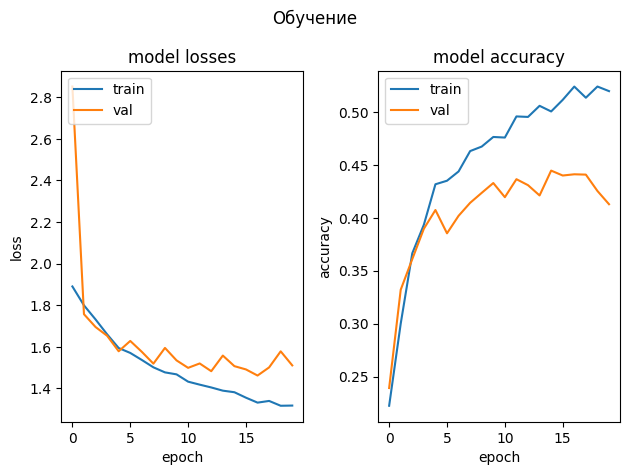

In [60]:
fig, axe = plt.subplots(1, 2)
fig.suptitle('Обучение')

axe[0].plot(train_losses[1:])
axe[0].plot(val_losses[1:])
axe[0].set_title('model losses')
axe[0].set_ylabel('loss')
axe[0].set_xlabel('epoch')
axe[0].legend(['train', 'val'], loc='upper left')

axe[1].plot(train_accuracies[1:])
axe[1].plot(val_accuracies[1:])
axe[1].set_title('model accuracy')
axe[1].set_ylabel('accuracy')
axe[1].set_xlabel('epoch')
axe[1].legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

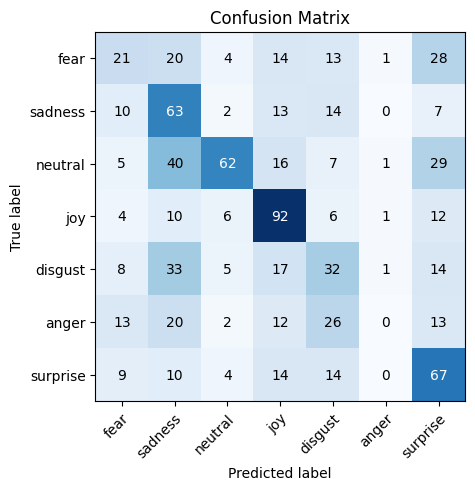

In [61]:
print_confusionmatrix(train_dataset, my_model, num_labels)

In [66]:
get_metrics(train_dataset['test'], my_model, id2label)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

,,fear,sadness,neutral,joy,disgust,anger,surprise
0,precision,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000
1,recall,0.207921,0.577982,0.387500,0.702290,0.290909,0.0,0.567797
2,f1_weighted,0.344262,0.732558,0.558559,0.825112,0.450704,0.0,0.724324
3,f1_micro,0.207921,0.577982,0.387500,0.702290,0.290909,0.0,0.567797
4,f1_macro,0.049180,0.122093,0.079794,0.117873,0.064386,0.0,0.120721


In [63]:
from huggingface_hub import notebook_login

notebook_login()

In [64]:
my_model.push_to_hub("rubert-tiny2-cedr-rnc-emotion-detection")
tokenizer.push_to_hub("rubert-tiny2-cedr-rnc-emotion-detection")

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kplro/rubert-tiny2-cedr-rnc-emotion-detection/commit/95cc22d51e6872a54caafb093edf3e83a955bca3', commit_message='Upload tokenizer', commit_description='', oid='95cc22d51e6872a54caafb093edf3e83a955bca3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kplro/rubert-tiny2-cedr-rnc-emotion-detection', endpoint='https://huggingface.co', repo_type='model', repo_id='kplro/rubert-tiny2-cedr-rnc-emotion-detection'), pr_revision=None, pr_num=None)